In [1]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import myfm

# read movielens 100k data.
from movielens100k_data import MovieLens100kDataManager
data_manager = MovieLens100kDataManager()
df_train, df_test = data_manager.load_rating(fold=3) # Note the dependence on the fold

In [2]:
df_train.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,1997-09-22 22:02:38
1,1,2,3,1997-10-15 05:26:11
2,1,3,4,1997-11-03 07:42:40
3,1,4,3,1997-10-15 05:25:19
4,1,6,5,1998-02-14 04:52:53


In [3]:
def test_myfm(df_train, df_test, rank=8, grouping=None, classification=False, n_iter=100, samples=95):
    explanation_columns = ['user_id', 'movie_id']
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train = ohe.fit_transform(df_train[explanation_columns])
    X_test = ohe.transform(df_test[explanation_columns])
    y_train = df_train.rating.values
    y_test = df_test.rating.values
    if classification:
        y_train = y_train >= 4
        y_test = y_test >=4
        fm = myfm.MyFMClassifier(rank=rank, random_seed=334)
    else:
        fm = myfm.MyFMRegressor(rank=rank, random_seed=114514)
    
    if grouping:
        grouping = [ i for i, category in enumerate(ohe.categories_) for _ in category]
    X_train *= 1
    X_test *= 1
    fm.fit(X_train, y_train, grouping=grouping, n_iter=n_iter, n_kept_samples=samples)
    
    if classification:
        prediction = fm.predict_proba(X_test)
        roc = metrics.roc_auc_score(y_test, prediction)
        ll = metrics.log_loss(y_test, prediction)
        print('roc={roc}, ll={ll}'.format(roc=roc, ll=ll))
    else:
        prediction = fm.predict(X_test)
        rmse = ((y_test - prediction) ** 2).mean() ** .5
        mae = np.abs(y_test - prediction).mean()
        print('rmse={rmse}, mae={mae}'.format(rmse=rmse, mae=mae))
    return fm

### Regression

In [4]:
# basic regression
test_myfm(df_train, df_test, rank=8, classification=False);

alpha = 1.48 w0 = 3.25 : 100%|██████████| 100/100 [00:03<00:00, 32.06it/s]


rmse=0.9032126256432309, mae=0.7116432524241613


In [5]:
# with grouping
fm = test_myfm(df_train, df_test, rank=8, grouping=True, classification=False)

alpha = 1.56 w0 = 3.33 : 100%|██████████| 100/100 [00:02<00:00, 38.55it/s]


rmse=0.8959382764109612, mae=0.7048050699780434


### Classification

In [6]:
test_myfm(df_train, df_test, rank=8, classification=True);

w0 = -0.08 : 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


roc=0.7684949499199077, ll=0.5698737002871702


In [7]:
test_myfm(df_train, df_test, rank=8, classification=True, grouping=True);

w0 = 0.05 : 100%|██████████| 100/100 [00:03<00:00, 28.89it/s]


roc=0.780003453569525, ll=0.5585675065393222


### Trace plot of hyper parameters

In [8]:
trace = fm.get_hyper_trace()
trace.head()

,alpha,mu_w[0],mu_w[1],lambda_w[0],lambda_w[1],"mu_V[0,0]","mu_V[0,1]","mu_V[0,2]","mu_V[0,3]","mu_V[0,4]",...,"lambda_V[0,6]","lambda_V[0,7]","lambda_V[1,0]","lambda_V[1,1]","lambda_V[1,2]","lambda_V[1,3]","lambda_V[1,4]","lambda_V[1,5]","lambda_V[1,6]","lambda_V[1,7]"
0,0.073773,0.006018,-0.006035,89.507136,92.954965,0.005440,-0.001998,0.006522,0.000406,0.003018,...,90.615565,87.789924,87.700658,92.864221,95.023675,90.240256,93.779026,97.351861,94.212066,96.556951
1,0.823766,0.006150,-0.005994,69.702488,87.734103,0.009213,-0.006327,0.012722,0.004314,-0.001403,...,81.259333,70.716241,85.296864,79.351382,94.142464,90.386882,89.931417,96.731566,86.594320,94.020810
2,1.019528,0.020704,-0.022278,19.366727,34.504144,0.009320,-0.010180,0.017261,0.006320,0.005899,...,70.352140,67.324905,84.830385,76.005177,96.019243,88.824597,77.604886,91.041832,83.228223,88.345500
3,1.103350,0.046012,-0.058776,8.879178,13.202024,0.000409,0.005552,0.018687,0.002652,0.005034,...,64.440459,59.419695,81.478598,70.549166,94.018143,80.611668,72.522781,84.047488,77.337652,79.566632
4,1.148178,0.016582,-0.114855,6.614319,6.673271,0.003834,0.002101,0.020910,-0.001028,-0.001767,...,62.543517,56.908170,72.655076,72.452431,88.205165,76.891227,72.619896,75.341820,71.355234,77.826458


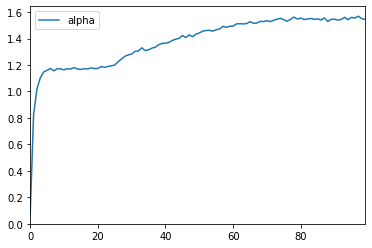

In [9]:
trace[['alpha']].plot();

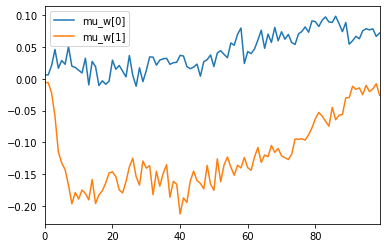

In [10]:
trace[[c for c in trace.columns if c.startswith('mu_w')]].plot();

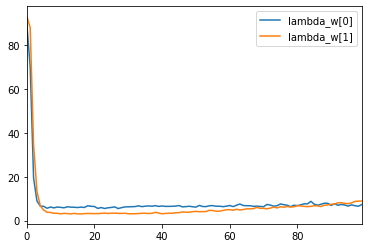

In [11]:
trace[[c for c in trace.columns if c.startswith('lambda_w')]].plot();

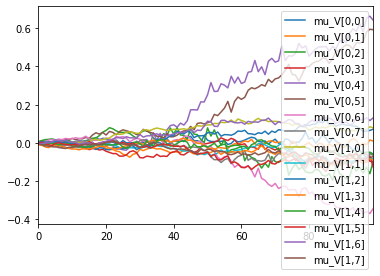

In [12]:
trace[[c for c in trace.columns if c.startswith('mu_V')]].plot();

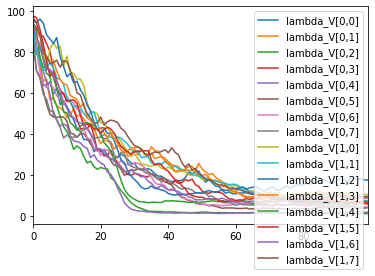

In [13]:
trace[[c for c in trace.columns if c.startswith('lambda_V')]].plot();